In [21]:
#pip install ee

In [22]:
#pip install geemap

# Import Libraries

In [66]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [149]:
# Read the lake names from Excel data
data_path = '/Users/mindsmatter/Desktop/Lakes/Site_Information_2022_8_1 (2).xlsx'
df_lake_info = pd.read_excel(data_path, sheet_name='Sheet 1', usecols=['PROGRAM_ID', 'SITE_NAME', 'LATDD', 'LONDD'])

# Filter for lakes with 'PROGRAM_ID' matching the given condition (you can adjust the condition if needed)
target_lakes = [
    'Little Hope Pond', 'Big Hope Pond', 'East Copperas Pond', 'Sunday Pond',
    'Sochia Pond', 'Grass Pond (3)', 'Little Clear Pond', 'Black Pond Stream',
    'Willys Lake', 'Woods Lake', 'Middle Settlement Lake', 'Middle Branch Lake',
    'Limekiln Lake', 'Squaw Lake', 'Indian Lake', 'Brook Trout Lake', 'Lost Pond',
    'North Lake', 'Constable Pond Stream', 'Squash Pond Stream', 'West Pond Stream',
    'Windfall Pond Stream', 'Cascade Lake Stream', 'Bubb Lake Stream', 'Willis Lake',
    'Long Pond', 'Carry Pond', 'Lake Colden', 'Avalanche Lake', 'Little Simon Pond',
    'Raquette Lake Reservoir', 'Otter Lake Stream', 'G Lake', 'Constable Pond',
    'Middle Pond', 'Arbutus Pond', 'Sagamore Lake', 'Black Pond', 'Queer Lake',
    'Heart Lake', 'Big Moose Lake', 'Cascade Lake', 'Dart Lake', 'Little Echo Pond',
    'Moss Lake', 'Lake Rondaxe', 'Squash Pond', 'West Pond', 'Owen Pond',
    'Jockeybush Lake', 'Barnes Lake', 'Clear Pond', 'Otter Lake', 'Nate Pond',
    'Grass Pond', 'South Lake (East Branch)', 'Marcy Dam Pond', 'Loon Hollow Pond',
    'Windfall Pond'
]

# Function to create a five-sided polygon around the latitude and longitude
def create_lake_polygon(lat, lon):
    # Assuming each pixel is approximately 20 meters in size
    buffer_distance_meters = 2 * 20  
    
    # Convert buffer distance from meters to degrees (approximate conversion)
    buffer_distance_degrees = buffer_distance_meters / 111320.0
    
    # Define the coordinates of the five vertices of the polygon
    coordinates = [
        [lon, lat + buffer_distance_degrees],
        [lon + buffer_distance_degrees, lat + buffer_distance_degrees/2],
        [lon + buffer_distance_degrees/2, lat - buffer_distance_degrees/2],
        [lon - buffer_distance_degrees/2, lat - buffer_distance_degrees/2],
        [lon - buffer_distance_degrees, lat + buffer_distance_degrees/2]
    ]
    
    # Create the polygon geometry
    polygon = ee.Geometry.Polygon(coordinates)
    
    return polygon


In [150]:
# Function to process the data for a specific lake
def process_lake(lake_name, lat, lon):
    # Create a polygon around the lake using the latitude and longitude
    lake_polygon = create_lake_polygon(lat, lon)

    # Load the lake polygon to the map
    Map.addLayer(ee.Feature(lake_polygon), {'color': 'blue'}, lake_name)

# Load Sentinel-2 data and apply the processing steps for the lake
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filter(ee.Filter.calendarRange(1, 12, 'month')) \
        .filterBounds(lake_polygon) \
        .map(maskS2clouds) \
        .select(sentinel2_bands, STD_NAMES) \
        .map(lambda img: cdom(img, lake_polygon)) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25))

In [151]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

# Masking Clouds

In [152]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage

In [153]:
# Function to calculate CDOM from Sentinel-2 images
def cdom(img, lake):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake_polygon).updateMask(mask)

In [169]:
# Create a geemap Map
Map = geemap.Map()

# Get the list of lake names
lake_names = df_lake_info['SITE_NAME'].tolist()

# Prompt the user to enter the name of the lake they want to process
selected_lake = input("Enter the name of the lake you want to analyze: ")

# Check if the selected lake is in the list of lake names
if selected_lake not in lake_names:
    print("Lake not found. Please select a valid lake.")
else:
    # Get the information for the selected lake
    lake_info = df_lake_info[df_lake_info['SITE_NAME'] == selected_lake].iloc[0]
    lat = lake_info['LATDD']
    lon = lake_info['LONDD']

    # Create a polygon around the selected lake using the latitude and longitude
    lake_polygon = create_lake_polygon(lat, lon)

    # Call the process_lake function to process the data for the selected lake
    process_lake(selected_lake, lat, lon)

    # Center the map on the selected lake
    Map.centerObject(ee.Feature(lake_polygon), 14)
    
    # Display the map with the lake name as the image name
    Map.addLayer(s2.first(), {}, selected_lake + " Image")

# Display the map
Map.addLayerControl()
Map


Enter the name of the lake you want to analyze: Big Moose Lake


Map(center=[43.81694485887238, -74.85611000031606], controls=(WidgetControl(options=['position', 'transparent_…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

In [170]:
#Map.user_roi.getInfo()

In [171]:
#Map.addLayer(s2.first(), {}, lake_name + " Image")

In [172]:
# Convert the image collection to a list and get the last image
s2_list = s2.toList(s2.size())
last_image = ee.Image(s2_list.get(-1))
#geemap.image_props(last_image).getInfo()

In [173]:
#image = se.first()

In [174]:
imageFirst = s2.first()
#geemap.image_props(imageFirst).getInfo()

In [175]:
#print(s2.getInfo())

In [176]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [177]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [178]:
first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


In [179]:
#How many images?
print(s2.size().getInfo())


56


# CDOM

In [184]:
# Function to calculate mean CDOM value within a specified region
def station_mean(img, lake_polygon):
    # Mean of a specific band (CO) within a region
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake_polygon, scale=30).get('CO')
    return ee.Feature(None, {'date': img.date().format(), 'CDOM': mean})

# Create a five-sided polygon around the latitude and longitude
lake_polygon = create_lake_polygon(lat, lon)

# Filter Sentinel-2 data for the specified date range (2019-01-01 to 2023-12-31)
s2_filtered = s2.filterDate('2019-01-01', '2023-12-31')

# Map the station_mean function over the filtered ImageCollection
station_reduced_imgs = s2_filtered.map(lambda img: station_mean(img, lake_polygon))

# Convert the result to a list
nested_list = station_reduced_imgs.toList(station_reduced_imgs.size())

# Create an empty list to store the results
results = []

# Loop over the list and extract the date and CDOM values
for item in nested_list.getInfo():
    date = item['properties']['date']
    cdom_value = item['properties']['CDOM']
    results.append([date, cdom_value])

# Create a DataFrame to display the results
df = pd.DataFrame(results, columns=['date', 'CDOM'])

# Display the DataFrame
pd.set_option('display.max_rows', None)
print(df)


KeyError: 'CDOM'

In [183]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

TypeError: <class 'list'> is not convertible to datetime

In [50]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


# Reflectance Values

In [33]:
def reflectance(img): 
    #img is used to calculate the mean of specific bands indicated by STD_NAMES
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

s2_reflectance = s2.map(reflectance)
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

,date,reflectance
0,2019-06-15,"{'Aerosols': 368.425732589438, 'Blue': 311.837..."
1,2019-07-10,"{'Aerosols': 479.8491217632933, 'Blue': 488.53..."
2,2019-08-14,"{'Aerosols': 527.3004795658517, 'Blue': 512.25..."
3,2019-09-13,"{'Aerosols': 173.70285055102912, 'Blue': 125.3..."
4,2019-09-18,"{'Aerosols': 75.77990031414828, 'Blue': 84.410..."
5,2019-10-08,"{'Aerosols': 18.292760079226316, 'Blue': 46.80..."
6,2019-10-13,"{'Aerosols': 16.831288588364178, 'Blue': 9.654..."
7,2019-11-17,"{'Aerosols': 245.4442124284712, 'Blue': 208.23..."
8,2020-03-01,"{'Aerosols': 9635.495222479387, 'Blue': 9810.6..."
9,2020-03-16,"{'Aerosols': 3875.733046512808, 'Blue': 4117.9..."


In [34]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



         Band   Reflectance        Date
0    Aerosols    368.425733  2019-06-15
1        Blue    311.837608  2019-06-15
2       Green    291.985185  2019-06-15
3         Red    251.838602  2019-06-15
4    RedEdge1    286.937584  2019-06-15
5    RedEdge2    344.041768  2019-06-15
6    RedEdge4    377.376071  2019-06-15
7         NIR    383.845385  2019-06-15
8       SWIR1    316.281769  2019-06-15
9    Aerosols    479.849122  2019-07-10
10       Blue    488.531658  2019-07-10
11      Green    466.329754  2019-07-10
12        Red    348.598637  2019-07-10
13   RedEdge1    445.465738  2019-07-10
14   RedEdge2    846.526398  2019-07-10
15   RedEdge4    915.454195  2019-07-10
16        NIR    897.087309  2019-07-10
17      SWIR1    286.034491  2019-07-10
18   Aerosols    527.300480  2019-08-14
19       Blue    512.251261  2019-08-14
20      Green    506.790841  2019-08-14
21        Red    451.578410  2019-08-14
22   RedEdge1    554.510944  2019-08-14
23   RedEdge2    826.316622  2019-08-14


In [39]:
data_by_month = {}

    for img in lake_collection:
        date = img.date()
        month = date.get('month')

        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}

        for band in STD_NAMES:
            reflectance_value = img.reduceRegion(ee.Reducer.mean(), lake_polygon, 10).get(band)
            if reflectance_value is not None:
                reflectance_value /= 10000  # Convert from DN to reflectance
                data_by_month[month][band].append(reflectance_value)

    # Calculate the average reflectance values for each band within each month
    average_data = {'band': [], 'average_reflectance': []}

    for month, data in data_by_month.items():
        for band, reflectance_values in data.items():
            if reflectance_values:
                average_value = sum(reflectance_values) / len(reflectance_values)
                average_data['band'].append(band)
                average_data['average_reflectance'].append(average_value)

    # Create a dataframe from the average data and display it
    df_average_data = pd.DataFrame(average_data)
    print(df_average_data)

# Create a geemap Map
Map = geemap.Map()

# Loop over the target lake names and process each lake
for lake_name in target_lakes:
    process_lake(lake_name)

# Center the map on the first lake
Map.centerObject(df_lake_info.loc[df_lake_info['GNIS_Name'] == target_lakes[0], 'geometry'].values[0], 14)

# Display the map
Map.addLayerControl()
Map  # This will display the interactive map with the lakes and their data


        band  average_reflectance
0   Aerosols             0.036843
1       Blue             0.031184
2      Green             0.029199
3        Red             0.025184
4   RedEdge1             0.028694
5   RedEdge2             0.034404
6   RedEdge4             0.037738
7        NIR             0.038385
8      SWIR1             0.031628
9   Aerosols             0.047985
10      Blue             0.048853
11     Green             0.046633
12       Red             0.034860
13  RedEdge1             0.044547
14  RedEdge2             0.084653
15  RedEdge4             0.091545
16       NIR             0.089709
17     SWIR1             0.028603
18  Aerosols             0.052730
19      Blue             0.051225
20     Green             0.050679
21       Red             0.045158
22  RedEdge1             0.055451
23  RedEdge2             0.082632
24  RedEdge4             0.097997
25       NIR             0.096255
26     SWIR1             0.075599
27  Aerosols             0.012474
28      Blue  

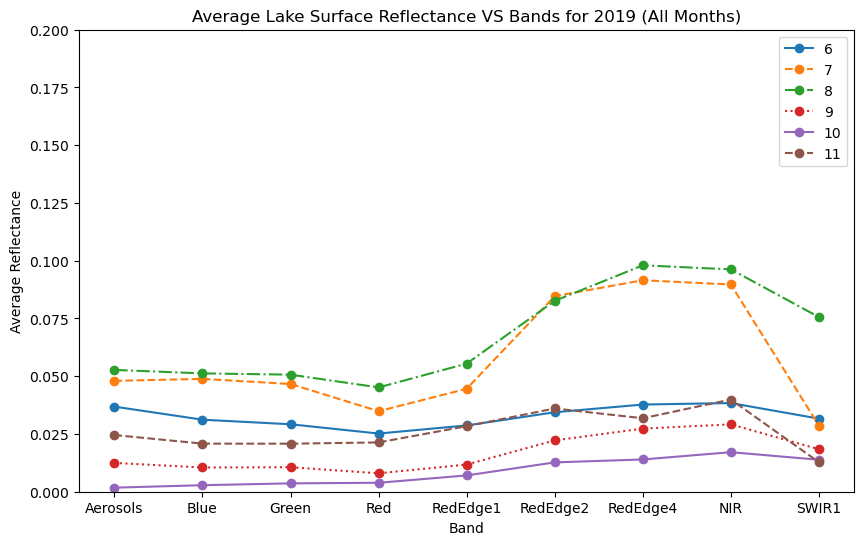

In [40]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()




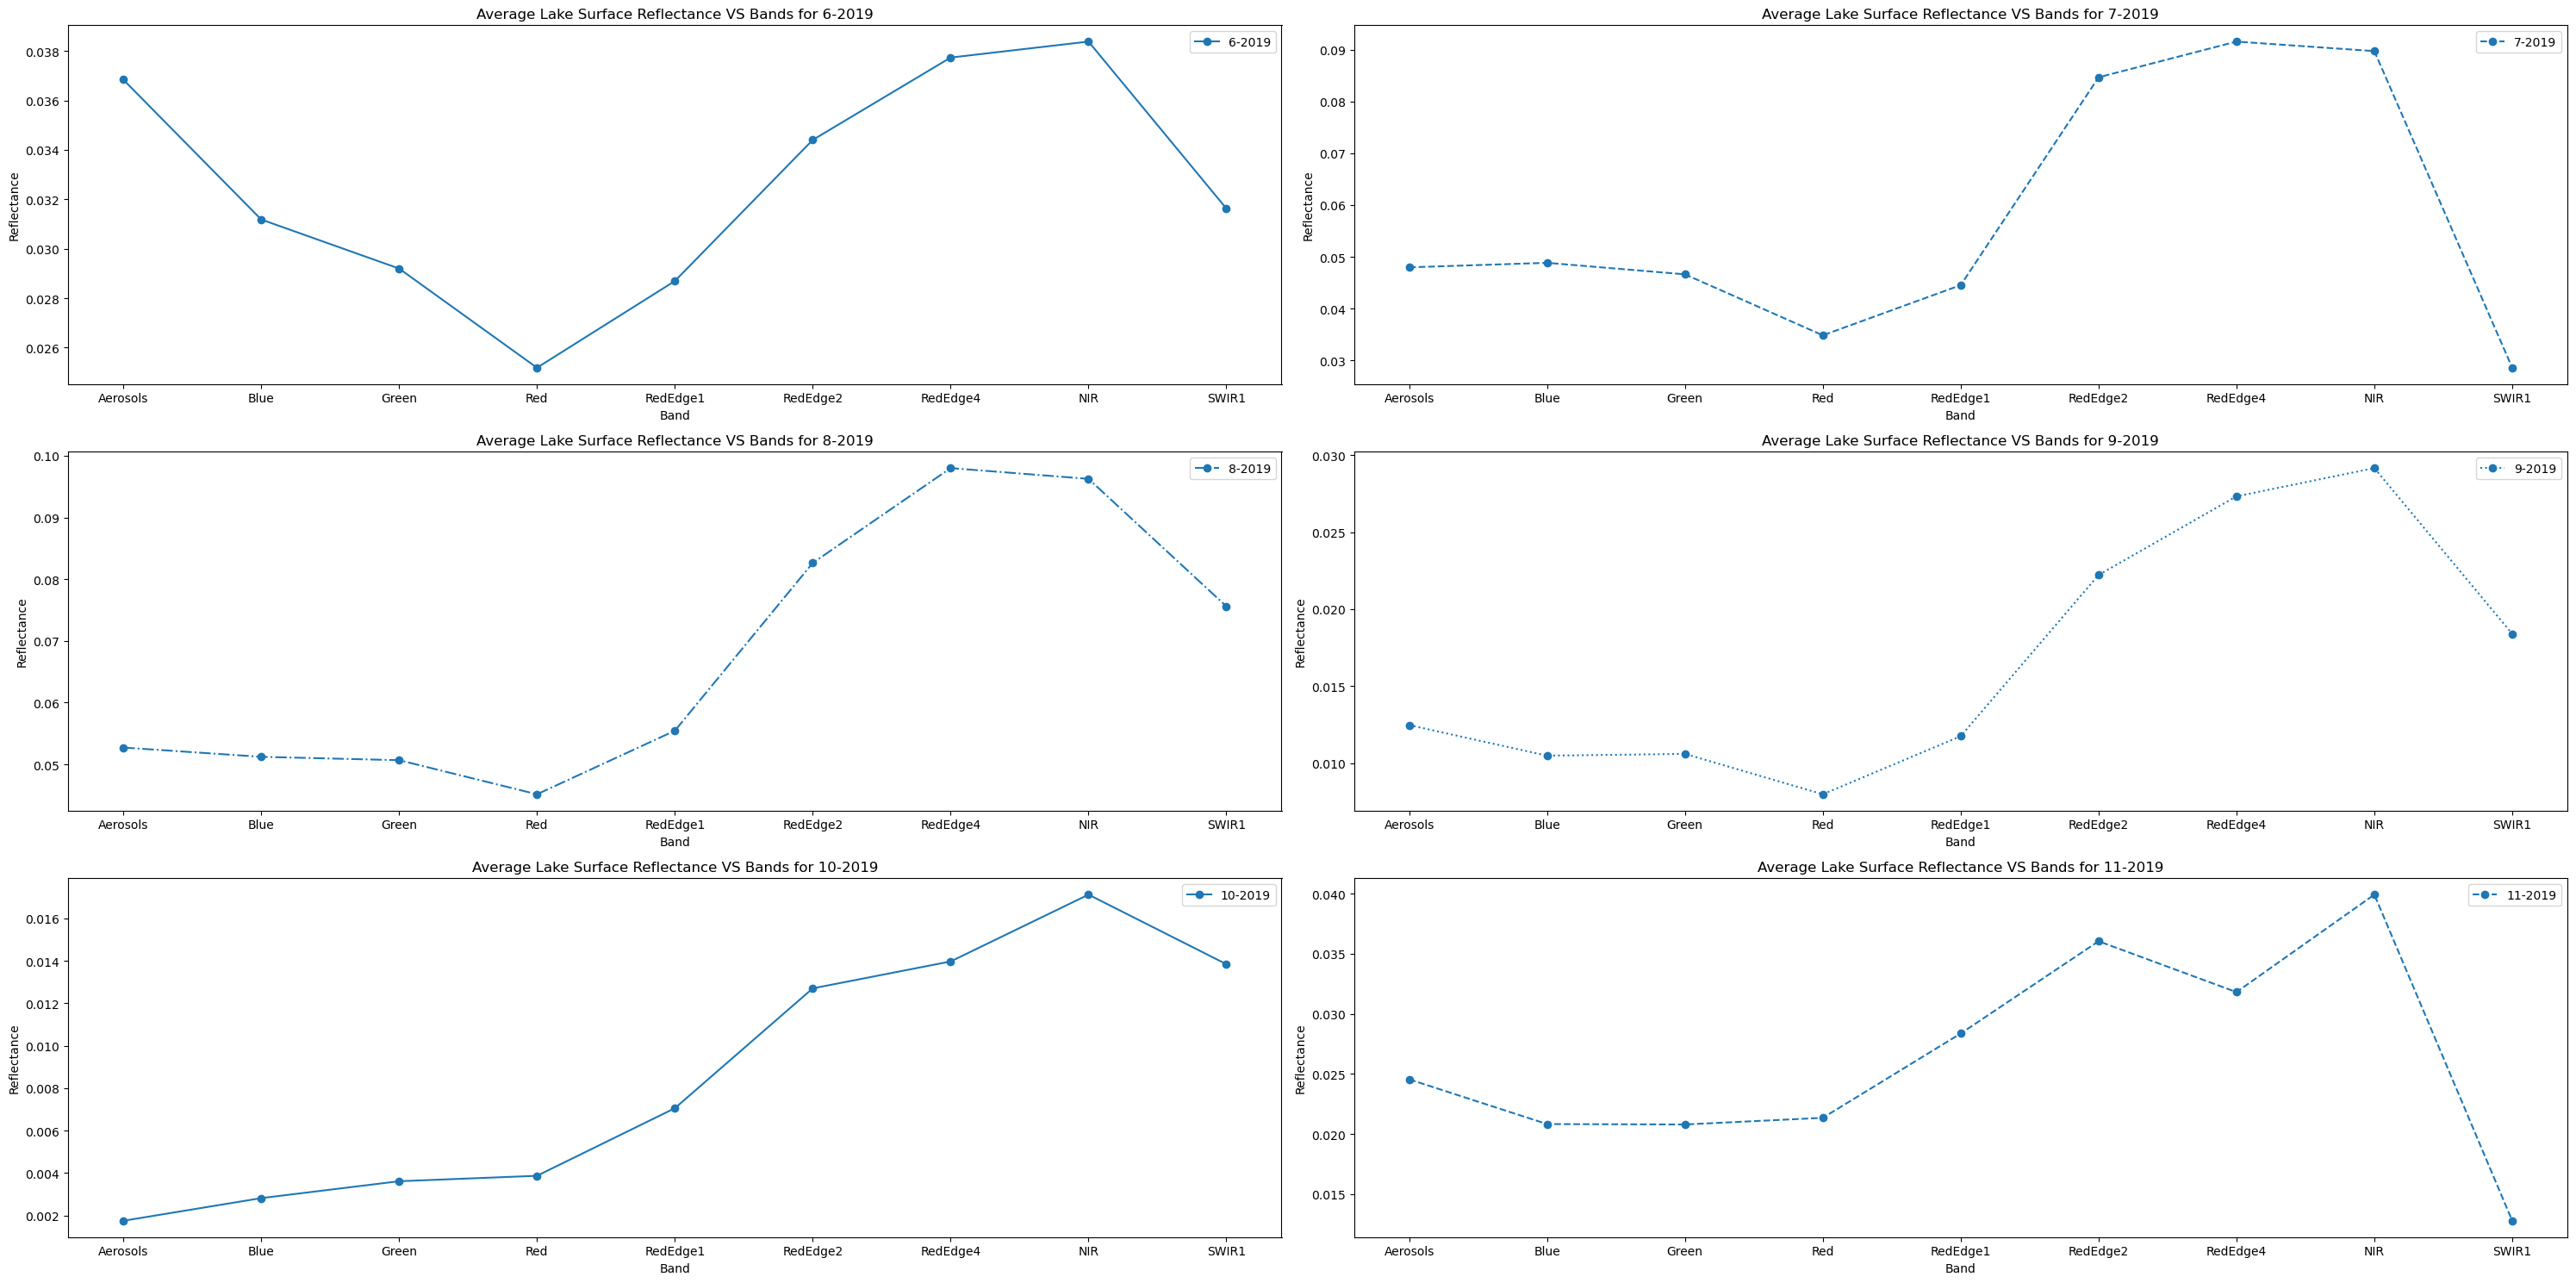

In [41]:
import numpy as np

data_by_month = {}

# Iterate over the dataframe rows
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    # Filter data for specific months
    if year == 2019 and date.month in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)
                else:
                    data_by_month[month][band].append(np.nan)

# Calculate the average reflectance values for each band within each month
averages_by_month = {
    month: {band: np.nanmean(values) for band, values in data.items()}
    for month, data in data_by_month.items()
}

# Define plot parameters
line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)

# Calculate the number of rows and columns for the subplots
num_months = len(data_by_month)
num_cols = 2  # Number of subplots per row
num_rows = (num_months + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Iterate over the data for each month
for i, (month, data) in enumerate(averages_by_month.items()):
    line_style = line_styles[i % num_styles]  # Cycle through line styles
    
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Reflectance')
    axs[i].set_title(f'Average Lake Surface Reflectance VS Bands for {month}-2019')
    
    bands = list(data.keys())
    reflectance_values = list(data.values())
    axs[i].plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-2019')
    
    axs[i].legend()

plt.tight_layout()
plt.show()





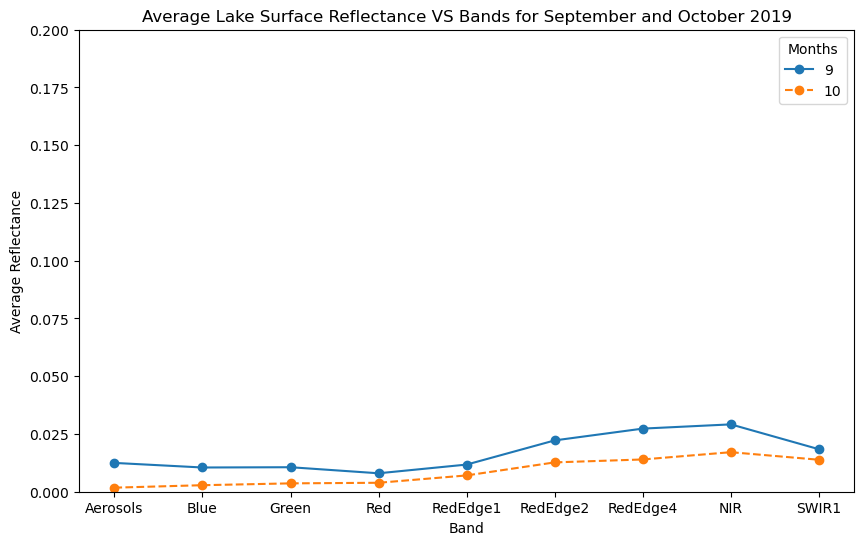

Data table for Month 9:
        band  reflectance
0   Aerosols     0.017370
1       Blue     0.012534
2      Green     0.013955
3        Red     0.010786
4   RedEdge1     0.015231
5   RedEdge2     0.026407
6   RedEdge4     0.033444
7        NIR     0.034191
8      SWIR1     0.022175
9   Aerosols     0.007578
10      Blue     0.008441
11     Green     0.007255
12       Red     0.005181
13  RedEdge1     0.008274
14  RedEdge2     0.018035
15  RedEdge4     0.021202
16       NIR     0.024120
17     SWIR1     0.014614

Data table for Month 10:
        band  reflectance
0   Aerosols     0.001829
1       Blue     0.004680
2      Green     0.004221
3        Red     0.004242
4   RedEdge1     0.007618
5   RedEdge2     0.014156
6   RedEdge4     0.015287
7        NIR     0.019336
8      SWIR1     0.014033
9   Aerosols     0.001683
10      Blue     0.000965
11     Green     0.003016
12       Red     0.003507
13  RedEdge1     0.006495
14  RedEdge2     0.011243
15  RedEdge4     0.012646
16       NIR  

In [42]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    month = date.month
    
    if year == 2019 and month in [9, 10]:  # Filter for September (9) and October (10) only
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--']  # List of line styles for two months
style_index = 0

for month, data in data_by_month.items():
    band_averages = {band: sum(data['reflectance'][i] for i, b in enumerate(data['band']) if b == band) / data['band'].count(band) for band in STD_NAMES}
    bands = list(band_averages.keys())
    reflectance_values = list(band_averages.values())
    
    line_style = line_styles[style_index]  # Cycle through line styles
    
    plt.plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}')
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September and October 2019')
plt.legend(title='Months')
plt.show()

# Display the data table for September and October
for month, data in data_by_month.items():
    print(f"Data table for Month {month}:")
    df = pd.DataFrame(data)
    print(df)
    print()



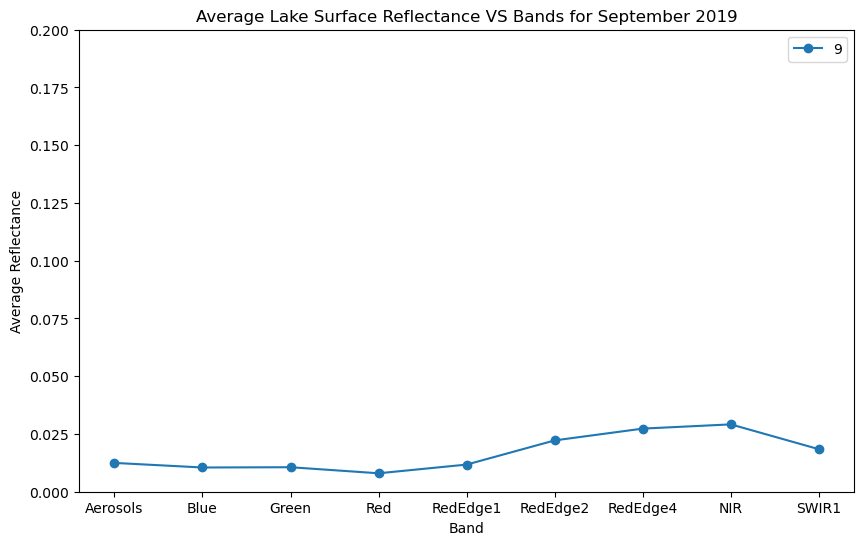

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded the data into df_s2_reflectance and defined STD_NAMES

data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    month = date.month
    
    if year == 2019 and month == 9:  # Filter for September (month 9) only
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)

averages_by_band = {
    band: sum(data) / len(data) for band, data in data_by_month[9].items()
}

plt.figure(figsize=(10, 6))

bands = list(averages_by_band.keys())
reflectance_values = list(averages_by_band.values())

plt.plot(bands, reflectance_values, linestyle='-', marker='o', label='9')

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September 2019')

plt.legend()
plt.show()





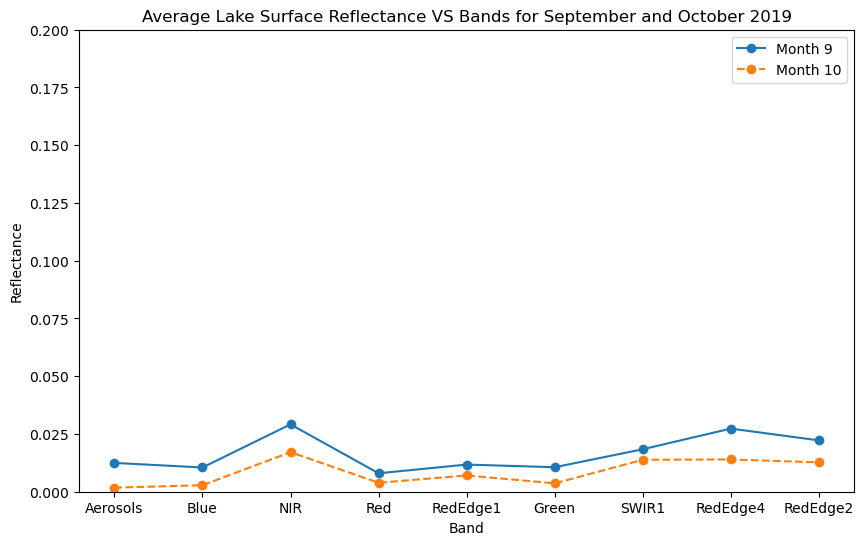

In [44]:
data_by_month = {}
monthly_average_reflectance = {}  # New dictionary to store average reflectance values

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month in [9, 10]:  # Only consider data for September (9) and October (10)
            if month not in data_by_month:
                data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
            
            if reflectance:
                for band in STD_NAMES:
                    value = reflectance.get(band)
                    if value is not None:
                        value /= 10000  # Divide by 10000 to convert from DN to reflectance
                        data_by_month[month]['band'].append(band)
                        data_by_month[month]['dates'].append(date)
                        data_by_month[month]['reflectance'].append(value)

# Calculate the average reflectance for each band for each month
for month, data in data_by_month.items():
    unique_bands = list(set(data['band']))
    average_reflectance = []
    for band in unique_bands:
        indices = [i for i, b in enumerate(data['band']) if b == band]
        reflectance_values = [data['reflectance'][i] for i in indices]
        avg_reflectance = sum(reflectance_values) / len(reflectance_values)
        average_reflectance.append(avg_reflectance)
    monthly_average_reflectance[month] = {'band': unique_bands, 'reflectance': average_reflectance}

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in monthly_average_reflectance.items():
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    plt.plot(data['band'], data['reflectance'], linestyle=line_style, marker='o', label=f"Month {month}")
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September and October 2019')
plt.legend()
plt.show()


# DOC

In [45]:
import pandas as pd

# Read the data from the Excel file
data_doc = pd.read_excel('/Users/mindsmatter/Desktop/Lakes/LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

# Filter data from 2016 onwards
data_doc = data_doc[data_doc['DATE_SMP'] >= '2019-01-01']

# Select the 'DATE_SMP' and 'DOC_MG_L' columns and filter by specific_site_id
specific_site_id = '1A1-103'  # BIG_MOOSE_LAKE
data = data_doc[data_doc['SITE_ID'] == specific_site_id][['DATE_SMP', 'DOC_MG_L','SITE_ID']].rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC'})

print(data)


            Date       DOC  SITE_ID
18861 2019-02-05  7.659300  1A1-103
38335 2019-04-02  6.400300  1A1-103
37120 2019-05-01  5.958300  1A1-103
16544 2019-07-09  5.888300  1A1-103
1887  2019-09-04  5.505700  1A1-103
38346 2019-11-14  7.429081  1A1-103
37128 2020-02-03  7.373080  1A1-103
5568  2020-05-28  5.758763  1A1-103
32198 2020-07-14  5.007855  1A1-103
16554 2020-09-01  4.970554  1A1-103
3125  2020-11-05  5.042800  1A1-103
28525 2021-02-03  6.499600  1A1-103
34632 2021-04-01  7.029300  1A1-103
1901  2021-05-04  6.989800  1A1-103
8040  2021-07-15  5.821500  1A1-103
11687 2021-09-02  7.912200  1A1-103


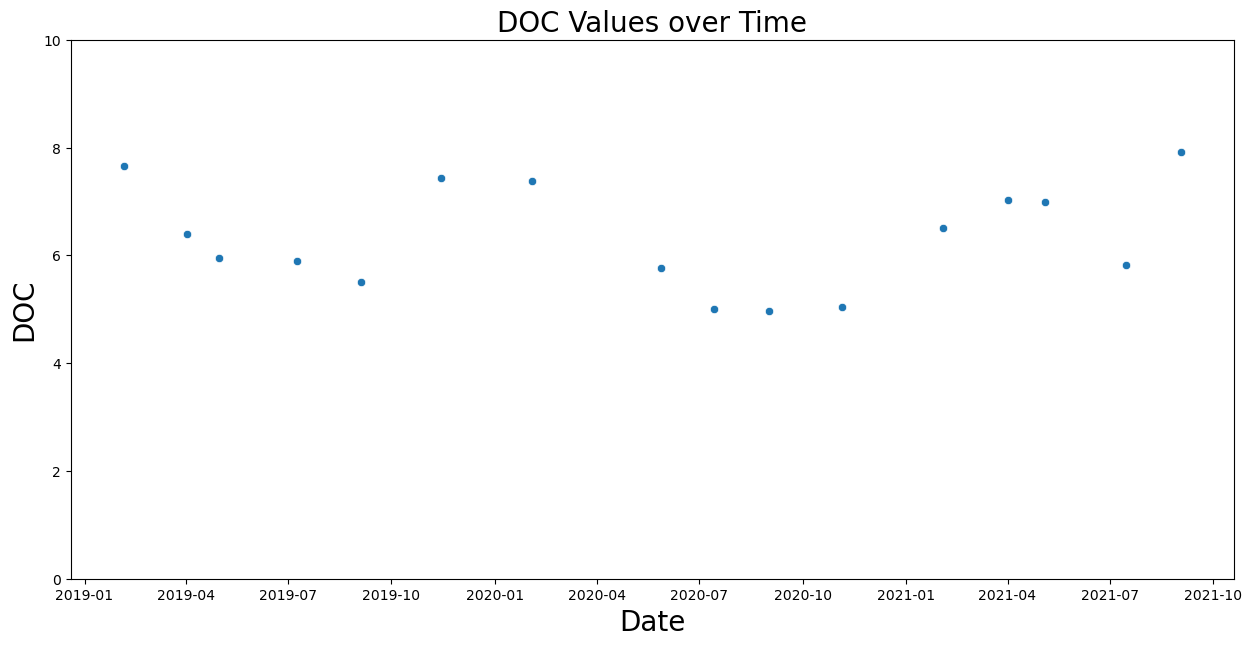

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=data, x='Date', y='DOC', ax=ax)

# Set the labels and title
ax.set_ylabel('DOC', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('DOC Values over Time', fontsize=20)
ax.set_ylim(0, 10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))
#
# Display the plot
plt.show()


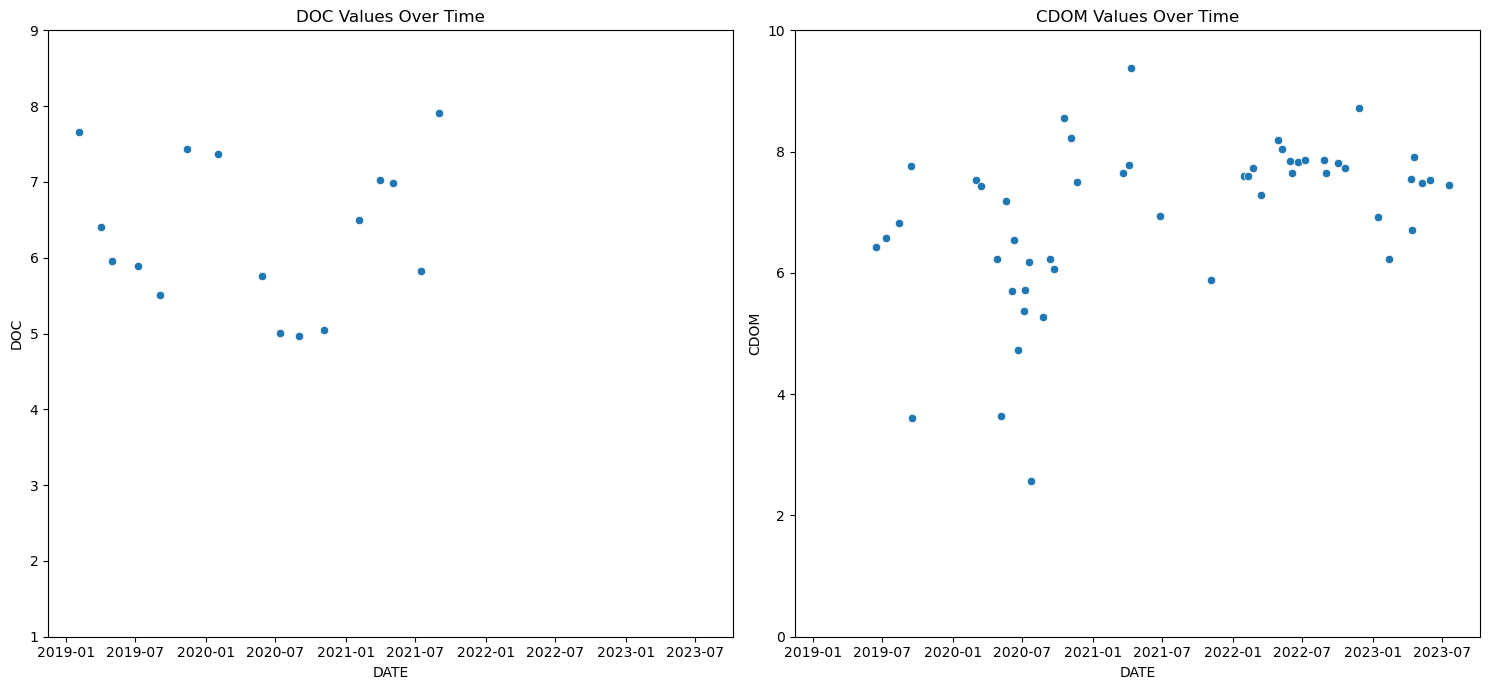

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x='Date', y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_ylim(1,9)

ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_ylim(0,10)
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

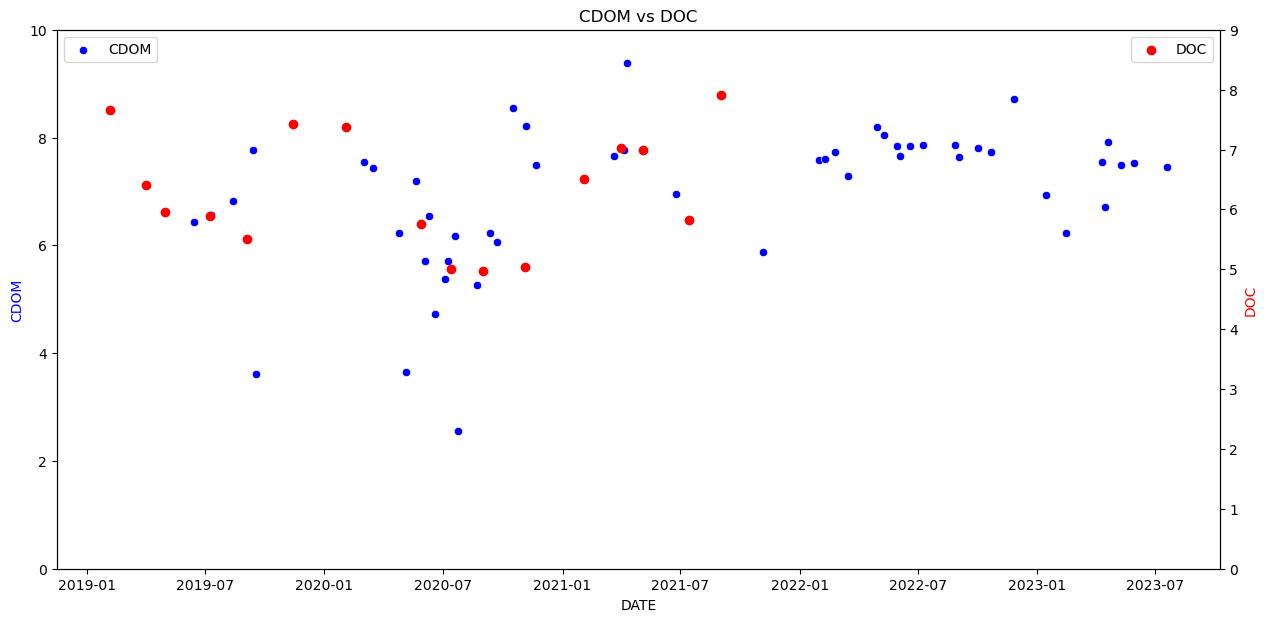

In [53]:
# CDOM vs DOC Timeseries
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data['Date'], data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0,10)  # Adjust the range for CDOM
ax2.set_ylim(0, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

In [54]:
# Sort the doc DataFrame by date in ascending order
data = data.sort_values(by='Date')

# Sort the keys in the 'date' column of df(CDOM) in ascending order
df.sort_values('date', inplace=True)

# Convert 'date' column in df(CDOM) to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Perform inner merge with five-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_on='Date', tolerance=pd.Timedelta(days=5))

# Get rid of the null values from doc
merged_inner = merged_inner.dropna()

print(merged_inner)




         date         CDOM       Date       DOC  SITE_ID
1  2019-07-10     6.571414 2019-07-09  5.888300  1A1-103
7  2019-11-17  1277.846320 2019-11-14  7.429081  1A1-103
18 2020-07-19     6.178304 2020-07-14  5.007855  1A1-103
24 2020-11-06     8.221086 2020-11-05  5.042800  1A1-103
27 2021-04-05     7.776528 2021-04-01  7.029300  1A1-103


In [55]:
# Drop duplicate rows based on DOC column, keeping the first occurrence
merged_inner = merged_inner.drop_duplicates(subset=['DOC'])

# Print the updated DataFrame
#print(merged_inner)

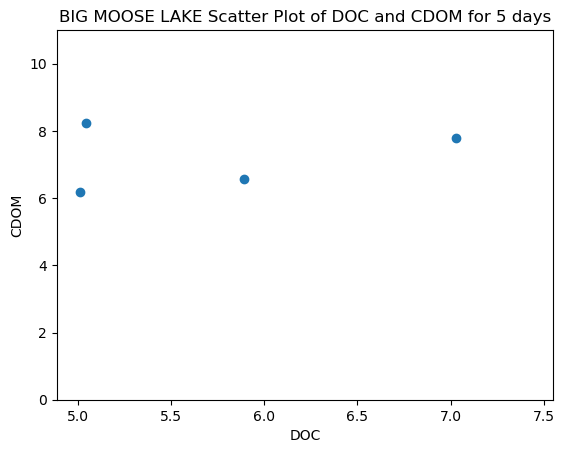

In [56]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(merged_inner['DOC'], merged_inner['CDOM'])
# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('BIG MOOSE LAKE Scatter Plot of DOC and CDOM for 5 days')
plt.ylim(0,11)
# Displaying the plot
plt.show()

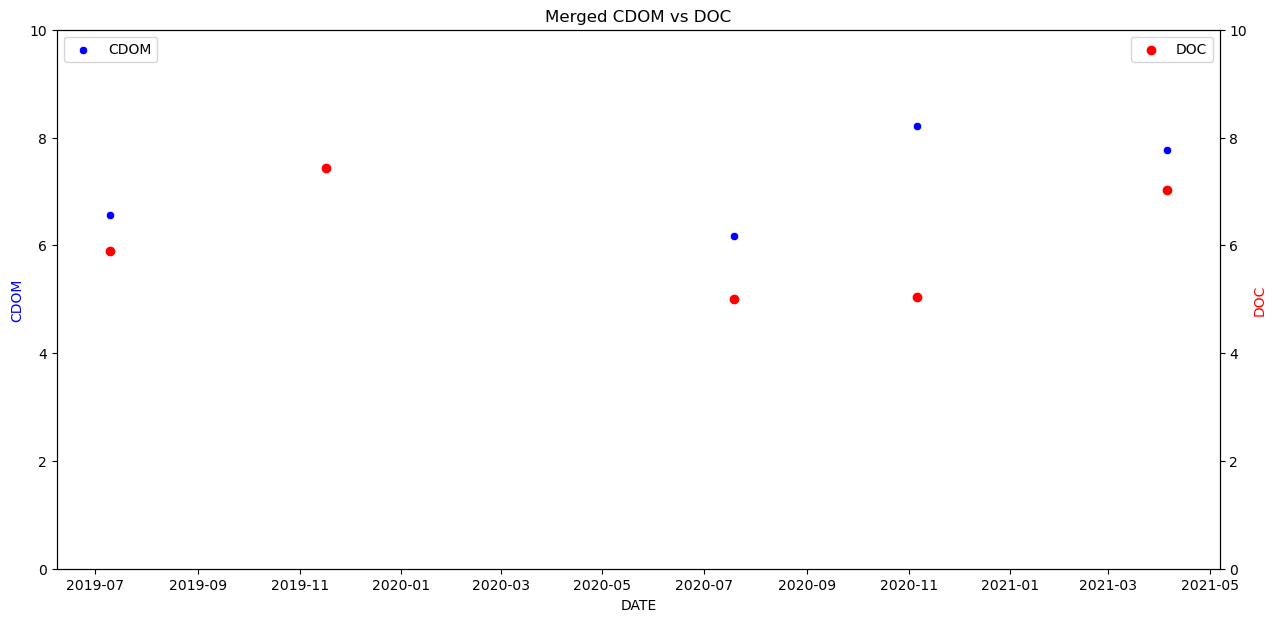

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=merged_inner, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(0, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

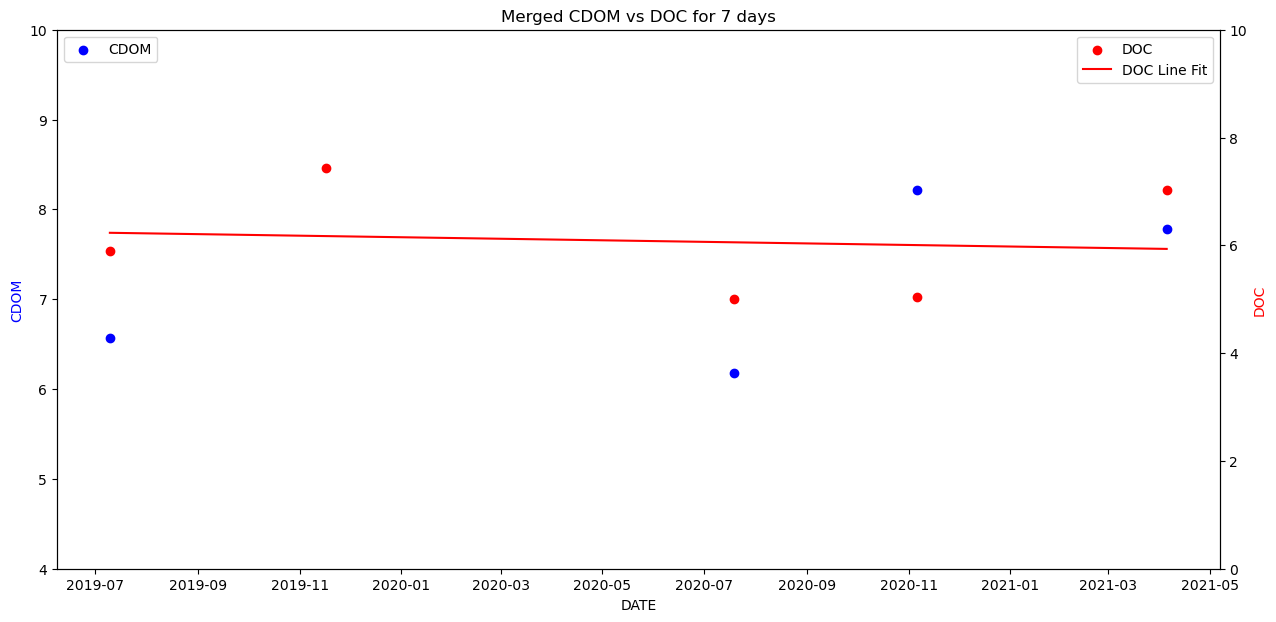

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert the date values to numeric format
merged_inner['date_numeric'] = pd.to_numeric(merged_inner['date']).astype(float)

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot 
ax.scatter(merged_inner['date'], merged_inner['CDOM'], label='CDOM', color='blue')


# Create a twin Axes object for DOC
ax2 = ax.twinx()
ax2.scatter(merged_inner['date'], merged_inner['DOC'], label='DOC', color='red')


# Calculate the linear regression line for CDOM
cdom_x = merged_inner['date_numeric']
cdom_y = merged_inner['CDOM']
cdom_slope, cdom_intercept = np.polyfit(cdom_x, cdom_y, 1)
cdom_line = cdom_slope * cdom_x + cdom_intercept
#ax.plot(merged_inner['date'], cdom_line, color='blue', label='CDOM Line Fit')

# Calculate the linear regression line for DOC
doc_x = merged_inner['date_numeric']
doc_y = merged_inner['DOC']
doc_slope, doc_intercept = np.polyfit(doc_x, doc_y, 1)
doc_line = doc_slope * doc_x + doc_intercept
ax2.plot(merged_inner['date'], doc_line, color='red', label='DOC Line Fit')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('Merged CDOM vs DOC for 7 days')

# Set different ranges for the y-axes
ax.set_ylim(4, 10)  # Adjust the range for CDOM
ax2.set_ylim(0, 10)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()